In [91]:
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
import os
import pandas as pd
import random
from sklearn.model_selection import train_test_split

class SelfAttention(nn.Module):
  def __init__(self, embed_size, heads):
    super(SelfAttention, self).__init__()
    self.embed_size = embed_size
    self.heads = heads
    self.head_dim = embed_size // heads

    assert (self.head_dim * heads == embed_size), "Embed size need to be div by heads"

    self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
    self.keys = nn.Linear(self.head_dim, self.head_dim, bias=False)
    self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False)
    self.fc_out = nn.Linear(heads*self.head_dim, embed_size) ## fully connected

  def forward(self, values, keys, query, mask):
    N = query.shape[0] # how many examples we are sending in at the same time
    value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1] ## corresponds to source sentence lenght and target sentence length
    
    # Split embedding into self.heads pieces
    values = values.reshape(N, value_len, self.heads, self.head_dim)
    keys = keys.reshape(N, key_len, self.heads, self.head_dim)
    queries = query.reshape(N, query_len, self.heads, self.head_dim)   

    values = self.values(values)
    keys = self.keys(keys)
    queries = self.queries(queries)

    energy = torch.einsum("nqhd, nkhd->nhqk", [queries, keys])    # used for matrix multiplication
    # queries shape: (N, query_len, heads, heads_dim)
    # keys shape: (N, keys_len, heads, heads_dim)
    # energy shape: (N, heads, query_len, keys_len)
    if mask is not None:
      energy = energy.masked_fill(mask == 0, float("-1e20"))  # if element of mask is zero, we want to shut it off (not inpact other), set it to -Inf
    
    attention = torch.softmax(energy / (self.embed_size ** (1/2)), dim = 3) ## normalizing across key length, i.e.

    out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(
        N, query_len, self.heads*self.head_dim
    )
    # attention shape: (N, heads, query_len, key_len)
    # values shape: (N, value_len, heads, heads_dim)
    # out: (N, query_len, heads, head_dim) 
    # then flatten last two dim, to concat.

    out = self.fc_out(out)
    return out



class TransformerBlock(nn.Module):
  def __init__(self, embed_size, heads, dropout, forward_expansion):
    super(TransformerBlock, self).__init__()
    self.attention = SelfAttention(embed_size, heads)
    self.norm1 = nn.LayerNorm(embed_size) # normalization, LayerNorm
    self.norm2 = nn.LayerNorm(embed_size)

    self.feed_forward = nn.Sequential(
        nn.Linear(embed_size, forward_expansion * embed_size),
        nn.ReLU(),
        nn.Linear(forward_expansion*embed_size, embed_size)
    )
    self.dropout = nn.Dropout(dropout)
  
  def forward(self, value, key, query, mask):
    attention = self.attention(value, key, query, mask)

    x = self.dropout(self.norm1(attention + query)) # send in skip connection
    forward = self.feed_forward(x)
    out = self.dropout(self.norm2(forward + x))
    return out



class Encoder(nn.Module):
  def __init__(
      self,
      src_vocab_size,
      embed_size,
      num_layers,
      heads,
      device,
      forward_expansion,
      dropout,
      max_length
  ):
    super(Encoder, self).__init__()
    self.embed_size = embed_size
    self.device = device
    print(src_vocab_size, embed_size)
    self.word_embedding = nn.Embedding(src_vocab_size, embed_size)
    print(src_vocab_size, embed_size)
    

    self.position_embedding = nn.Embedding(max_length, embed_size)
    self.layers = nn.ModuleList(
        [
         TransformerBlock(
             embed_size,
             heads,
             dropout=dropout,
             forward_expansion=forward_expansion,
         )
       for _ in range(num_layers) ]
    )

    self.dropout = nn.Dropout(dropout)

  def forward(self, x, mask):
    N, seq_length = x.shape
    positions = torch.arange(0, seq_length).expand(N, seq_length).to(self.device)

    out = self.dropout(self.word_embedding(x) + self.position_embedding(positions))

    for layer in self.layers:
      out = layer(out, out, out, mask)

    return out


class DecoderBlock(nn.Module):
  def __init__(self, embed_size, heads, forward_expansion, dropout, device):
    super(DecoderBlock, self).__init__()
    self.attention = SelfAttention(embed_size, heads)
    self.norm = nn.LayerNorm(embed_size)
    self.transformer_block = TransformerBlock(
        embed_size, heads, dropout, forward_expansion
    )
    self.dropout = nn.Dropout(dropout)

  def forward(self, x, value, key, src_mask, trg_mask):
    attention = self.attention(x, x, x, trg_mask)
    query = self.dropout(self.norm(attention + x))
    out = self.transformer_block(value, key, query, src_mask)
    return out

class Decoder(nn.Module):
  def __init__(self, trg_vocab_size, embed_size, num_layers, heads, forward_expansion, dropout, device, max_length):
    super(Decoder, self).__init__()
    self.device = device
    self.word_embedding = nn.Embedding(trg_vocab_size, embed_size)
    self.position_embedding = nn.Embedding(max_length, embed_size)

    self.layers = nn.ModuleList(
        [DecoderBlock(embed_size, heads, forward_expansion, dropout, device)
        for _ in range(num_layers)]
    )
    self.fc_out = nn.Linear(embed_size, trg_vocab_size)
    self.dropout = nn.Dropout(dropout)
  
  def forward(self, x, enc_out, src_mask, trg_mask):
    N, seq_length = x.shape
    positions = torch.arange(0, seq_length).expand(N, seq_length).to(self.device)
    x = self.dropout((self.word_embedding(x) + self.position_embedding(positions)))
    for layer in self.layers:
      x = layer(x, enc_out, enc_out, src_mask, trg_mask)

    out = self.fc_out(x)
    return out


class Transformer(nn.Module):
  def __init__(self, 
               src_vocab_size, 
               trg_vocab_size, 
               src_pad_idx, 
               trg_pad_idx, 
               embed_size=256, 
               num_layers=6, 
               forward_expansion=4, 
               heads=8, 
               dropout=0, 
               device="cuda", 
               max_length=100):
    super(Transformer, self).__init__()

    self.encoder = Encoder(
        src_vocab_size,
        embed_size,
        num_layers,
        heads,
        device,
        forward_expansion,
        dropout,
        max_length
    )

    self.decoder = Decoder(
        trg_vocab_size,
        embed_size,
        num_layers,
        heads,
        forward_expansion,
        dropout,
        device,
        max_length
    )

    self.src_pad_idx = src_pad_idx
    self.trg_pad_idx = trg_pad_idx
    self.device = device

  def make_src_mask(self, src):
    src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
    # (N, 1, 1 src_len)
    return src_mask.to(self.device)

  def make_trg_mask(self, trg):
    N, trg_len = trg.shape
    trg_mask = torch.tril(torch.ones((trg_len, trg_len))).expand(
        N, 1, trg_len, trg_len
    )
    return trg_mask.to(self.device)

  def forward(self, src, trg):
    src_mask = self.make_src_mask(src)
    trg_mask = self.make_trg_mask(trg)
    enc_src = self.encoder(src, src_mask)
    out = self.decoder(trg, enc_src, src_mask, trg_mask)
    return out




In [98]:
data = pd.read_csv("traj_data_v1.csv")

In [99]:
data.describe()

,Unnamed: 0,Vehicle_ID,X,Y,X_REL,Y_REL
count,134363.000000,134363.000000,1.343630e+05,1.343630e+05,134363.000000,134363.000000
mean,67181.000000,1522.586002,6.037205e+06,1.893112e+06,25.013277,-20.563577
std,38787.401447,906.737134,1.109129e+06,1.831537e+05,34.361927,63.308456
min,0.000000,2.000000,2.230484e+06,1.375551e+06,-104.242000,-329.272000
25%,33590.500000,753.000000,6.042875e+06,1.873242e+06,-0.464000,-58.563500
50%,67181.000000,1479.000000,6.451159e+06,1.873308e+06,14.445000,-18.858000
75%,100771.500000,2262.000000,6.451216e+06,1.874247e+06,42.681000,12.638500
max,134362.000000,3363.000000,6.452528e+06,2.133628e+06,236.273000,366.318000


In [100]:
len(data['Vehicle_ID'].unique())

2691

In [89]:
import random
from sklearn.model_selection import train_test_split
values = [[1,2,3],[2,2,3], [1,6,3], [1,2,5]]
yvalues = [[1,2,4],[2,2,3], [1,6,3], [1,2,5]]
test_dataset, training_dataset, x, y = train_test_split(values, yvalues, train_size=0.8)


In [101]:

# ############## TEST ##################
# test1 = pd.read_csv("test_traj_data.csv", sep="\t")
# test1.columns = ["Frame", "Vehicle_ID", "X", "Y"]

# ############### TRAIN ###############
# train1 = pd.read_csv("students_1.txt", sep="\t", header=None)
# train1.columns = ["Frame", "Ped", "X", "Y"]

def preprocess_dataset(data, max = 10, max_len = 40, input_len = 30):
    scaler = MinMaxScaler(feature_range=(0, max))
    data[['X_REL', 'Y_REL']] = scaler.fit_transform(data[['X_REL', 'Y_REL']])
    global map_dict
    map_dict = {}
    unique_peds = data['Vehicle_ID'].unique()
    unique_peds = sorted(unique_peds)
    inputs = []
    outputs = []
    seq = []
    for ped in unique_peds:
        if (len(data[data['Vehicle_ID'] == ped]) >= max_len):
          seq_inner = []
          target_inner = 0
          i = 0
          for indx, row in data[data['Vehicle_ID'] == ped].iterrows():
            x = round(row['X_REL'])
            y = round(row['Y_REL'])
            ## Cantor pairing function:
            bin = y * max + x
            #print("X: ", x, " Y: ", y, " Bin: ", bin)
            map_dict[int(bin)] = [int(x), int(y)]
            i += 1
            if i == max_len:
              break
            seq_inner.append(int(bin))
          inputs.append([seq_inner[0:input_len]])
          outputs.append([seq_inner[input_len + 1:]])
    train_inputs, test_inputs = train_test_split(inputs, train_size=0.7)
    train_inputs, test_inputs, train_targets, test_targets = train_test_split(inputs, outputs, train_size=0.8)
    
    return torch.tensor(train_inputs), torch.tensor(test_inputs), torch.tensor(train_targets), torch.tensor(test_targets)

train_data_inputs, test_data_inputs, train_data_targets, test_data_targets = preprocess_dataset(data, max = 50, max_len = 50, input_len = 20)
#test_data_inputs, test_data_targets = preprocess_dataset(test, max = 50, max_len = 50, input_len = 20)


In [102]:
test_data_inputs.shape

torch.Size([536, 1, 20])

In [104]:
train_data_targets.shape

torch.Size([2143, 1, 28])

In [105]:
if __name__ == "__main__":
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  # x = torch.tensor([[1, 5, 6, 4, 3, 9, 5, 2, 0], [1, 8, 7, 3, 4, 5, 6, 7, 2]]).to(device)
  # trg = torch.tensor([[1, 7, 4, 3, 5, 9, 2, 0], [1, 5, 6, 2, 4, 7, 6, 2]]).to(device)
  x = torch.tensor([[1, 8, 7, 3, 4, 5, 6, 7, 2]]).to(device)
  trg = torch.tensor([[1, 5, 6, 2, 4, 7, 6, 2]]).to(device)

  src_pad_idx = -999
  trg_pad_idx = -999
  src_vocab_size = 50*50 + 50
  trg_vocab_size = 50*50 + 50
  model = Transformer(src_vocab_size, trg_vocab_size, src_pad_idx, trg_pad_idx, device=device, dropout=0.15).to(device)


2550 256
2550 256


In [106]:
bptt = 5
criterion = nn.CrossEntropyLoss()
lr = 0.5 # learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

import time
import math
def train():
    model.train() # Turn on the train mode
    total_loss = 0.
    start_time = time.time()
    ntokens = 50*50 + 50
    for batch, i in enumerate(range(0, train_data_inputs.size(0), 1)):
      # data, targets = get_batch(train_data, i)
      data = train_data_inputs[i,:,:]
      targets = train_data_targets[i,:,:]
      optimizer.zero_grad()
      output = model(data, targets[:, :])
      # print(output.shape)
      # print(targets.shape)
      loss = criterion(output[0,:,:], targets[0,:])
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
      optimizer.step()

      total_loss += loss.item()
      log_interval = 200
        
    cur_loss = total_loss / train_data_inputs.size(0)
    print('lr {:02.2f} | '
                'loss {:5.2f} | ppl {:8.2f}'.format(
                  scheduler.get_lr()[0],
                  cur_loss, math.exp(cur_loss)))

def evaluate(eval_model, data_source_inputs, data_source_targets, get_preds=False):
    eval_model.eval() # Turn on the evaluation mode
    total_loss = 0.
    ntokens = 50*50 + 50
    with torch.no_grad():
        for i in range(0, data_source_inputs.size(0), 1):
            # data, targets = get_batch(data_source, i)
            data = data_source_inputs[i,:,:]
            targets = data_source_targets[i,:,:]
            output = eval_model(data, targets[:, :])
            output_flat = output
            if get_preds:
              # print(data)
              # print(torch.argmax(output[0,:,:], dim=1).shape)
              # print(targets[0,:-1].shape)
              # print(torch.argmax(output[0,:,:], dim=1))
              # print(targets[0,:-1])
              # print("--" * 30)
              vis_trajectory(torch.argmax(output[0,:,:], dim=1), targets[0,:])

            total_loss += 1 * criterion(output[0,:,:], targets[0,:]).item()
    return total_loss / (data_source_inputs.size(0))



def get_predictions(eval_model, data_source_inputs, data_source_targets):
    eval_model.eval() # Turn on the evaluation mode
    ntokens = 50*50 + 50
    preds_list = []
    target_list = []
    inputs_list = []
    with torch.no_grad():
        for i in range(0, data_source_inputs.size(0), 1):
            # data, targets = get_batch(data_source, i)
            data = data_source_inputs[i,:,:]
            targets = data_source_targets[i,:,:]
            output = eval_model(data, targets[:, :])
              # print(data)
              # print(torch.argmax(output[0,:,:], dim=1).shape)
              # print(targets[0,:-1].shape)
              # print(torch.argmax(output[0,:,:], dim=1))
              # print(targets[0,:-1])
              # print("--" * 30)
              # vis_trajectory(torch.argmax(output[0,:,:], dim=1), targets[0,:-1])
            preds_list.append(torch.argmax(output[0,:,:], dim=1).tolist())
            target_list.append(targets[0,:].tolist())
            inputs_list.append(data[0,:].tolist())

    return inputs_list, target_list, preds_list

In [107]:
best_val_loss = float("inf")
epochs = 50 # The number of epochs
best_model = None
early_stopping = 0

for epoch in range(1, epochs + 1):
  epoch_start_time = time.time()
  train()
  val_loss = evaluate(model, test_data_inputs, test_data_targets)
  print('-' * 89)
  print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.2f} | '
        'valid ppl {:8.2f}'.format(epoch, (time.time() - epoch_start_time),
                                    val_loss, math.exp(val_loss)))
  print('-' * 89)

  early_stopping = early_stopping + 1

  if val_loss < best_val_loss:
    early_stopping = 0
    best_val_loss = val_loss
    best_model = model


  if early_stopping > 10:
    break

  scheduler.step()

C:\Users\daavi\Anaconda3\envs\transformers\lib\site-packages\torch\optim\lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


lr 0.50 | loss  2.13 | ppl     8.42
-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 236.51s | valid loss  0.97 | valid ppl     2.64
-----------------------------------------------------------------------------------------
lr 0.45 | loss  0.81 | ppl     2.26
-----------------------------------------------------------------------------------------
| end of epoch   2 | time: 221.58s | valid loss  0.56 | valid ppl     1.76
-----------------------------------------------------------------------------------------
lr 0.43 | loss  0.52 | ppl     1.69
-----------------------------------------------------------------------------------------
| end of epoch   3 | time: 217.91s | valid loss  0.37 | valid ppl     1.45
-----------------------------------------------------------------------------------------
lr 0.41 | loss  0.37 | ppl     1.45
-----------------------------------------------------------------------------------------
|

KeyboardInterrupt: 

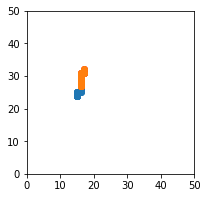

Input:  [[15, 24], [15, 24], [15, 24], [15, 24], [15, 24], [15, 24], [15, 24], [15, 24], [15, 25], [15, 25], [15, 25], [15, 25], [15, 25], [16, 25], [16, 25], [16, 26], [16, 26], [16, 26], [16, 26], [16, 26]]
Preds:  [[16, 27], [16, 27], [16, 27], [16, 27], [16, 27], [16, 27], [16, 28], [16, 28], [16, 28], [16, 28], [16, 28], [16, 28], [16, 29], [16, 29], [16, 29], [16, 29], [16, 29], [16, 30], [16, 30], [16, 30], [16, 30], [16, 30], [16, 31], [16, 31], [17, 31], [17, 31], [17, 31], [17, 32]]
Truth:  [[16, 27], [16, 27], [16, 27], [16, 27], [16, 27], [16, 27], [16, 28], [16, 28], [16, 28], [16, 28], [16, 28], [16, 28], [16, 29], [16, 29], [16, 29], [16, 29], [16, 29], [16, 30], [16, 30], [16, 30], [16, 30], [16, 30], [16, 31], [16, 31], [17, 31], [17, 31], [17, 31], [17, 32]]


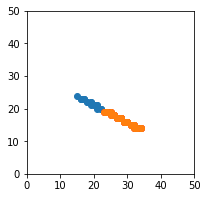

Input:  [[15, 24], [16, 23], [16, 23], [16, 23], [17, 23], [17, 23], [17, 23], [18, 22], [18, 22], [19, 22], [19, 22], [19, 21], [20, 21], [20, 21], [21, 21], [21, 21], [21, 20], [22, 20], [22, 20], [22, 20]]
Preds:  [[23, 19], [24, 19], [24, 19], [24, 19], [25, 19], [25, 18], [26, 18], [26, 18], [26, 18], [27, 17], [27, 17], [28, 17], [28, 17], [28, 17], [29, 16], [29, 16], [30, 16], [30, 16], [30, 16], [31, 15], [31, 15], [32, 15], [32, 15], [32, 14], [33, 14], [33, 14], [34, 14], [34, 14]]
Truth:  [[23, 19], [24, 19], [24, 19], [24, 19], [25, 19], [25, 18], [26, 18], [26, 18], [26, 18], [27, 17], [27, 17], [28, 17], [28, 17], [28, 17], [29, 16], [29, 16], [30, 16], [30, 16], [30, 16], [31, 15], [31, 15], [32, 15], [32, 15], [32, 14], [33, 14], [33, 14], [34, 14], [34, 14]]


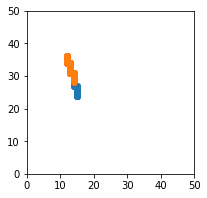

Input:  [[15, 24], [15, 24], [15, 24], [15, 24], [15, 25], [15, 25], [15, 25], [15, 25], [15, 25], [15, 26], [15, 26], [15, 26], [15, 26], [15, 27], [15, 27], [14, 27], [14, 27], [14, 27], [14, 28], [14, 28]]
Preds:  [[14, 28], [14, 29], [14, 29], [14, 29], [14, 29], [14, 29], [14, 30], [14, 30], [14, 30], [14, 30], [14, 31], [13, 31], [13, 31], [13, 32], [13, 32], [13, 32], [13, 33], [13, 33], [13, 33], [13, 34], [13, 34], [13, 34], [12, 34], [12, 35], [12, 35], [12, 35], [12, 36], [12, 36]]
Truth:  [[14, 28], [14, 29], [14, 29], [14, 29], [14, 29], [14, 29], [14, 30], [14, 30], [14, 30], [14, 30], [14, 31], [13, 31], [13, 31], [13, 32], [13, 32], [13, 32], [13, 33], [13, 33], [13, 33], [13, 34], [13, 34], [13, 34], [12, 34], [12, 35], [12, 35], [12, 35], [12, 36], [12, 36]]


KeyboardInterrupt: 

In [108]:
vis_trajectory_scatter(best_model, test_data_inputs, test_data_targets)

In [32]:
import numpy as np
import matplotlib.pyplot as plt

def vis_trajectory_scatter(best_model, data_src_inputs, data_src_targets, lag_time = 10.0):
  input_list, target_list, preds_list = get_predictions(best_model, data_src_inputs, data_src_targets)


  min_val, max_val = 0, 50
  
  for i in range(0, len(input_list)):
    # fig, ax = plt.subplots()
    plt.figure(figsize=(3,3))
    inputs = input_list[i]
    targets = target_list[i]
    preds = preds_list[i]

    xy_inputs = []
    xy_preds = []
    xy_target = []


    for inp in inputs:
      cords = map_dict[inp] 
      xy_inputs.append(cords)

    for inp in preds:
      cords = map_dict[inp] 
      xy_preds.append(cords)

    for inp in targets:
      cords = map_dict[inp] 
      xy_target.append(cords)

    x_inp, y_inp = zip(*xy_inputs)
    x_tar, y_tar = zip(*xy_target)
    x_pred, y_pred = zip(*xy_preds)

    plt.scatter(x_inp,y_inp)
    plt.scatter(x_tar,y_tar, color='r')
    plt.scatter(x_pred,y_pred)

    plt.xlim(0, 50)
    plt.ylim(0, 50)

    plt.show()
    print("Input: ", xy_inputs)
    print("Preds: ", xy_preds)
    print("Truth: ", xy_target)
    time.sleep(lag_time)


In [ ]:

input_dim = 10
embedding_dim = 2
embedding = nn.Embedding(input_dim, embedding_dim)
err = False
if err:
    #Any input more than input_dim - 1, here input_dim = 10
    #Any input less than zero
    input_to_embed = torch.tensor([10])
else:
    input_to_embed = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
embed = embedding(input_to_embed)
print(embed)

IndexError: ignored